# IMU Table Width Analysis

This notebook analyzes IMU acceleration data to determine the width of a table based on phone movement patterns.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.integrate import cumulative_trapezoid, cumulative_simpson
import os

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

In [34]:
# Enhanced function to load IMU data with gyro support
def load_imu_data_enhanced(filepath):
    """Load IMU data from text file and return as DataFrame with optional gyro data"""
    acc_data = []
    gyro_data = []
    
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) == 5:
                timestamp = int(parts[0])
                if parts[1] == 'ACC':
                    acc_x = float(parts[2])
                    acc_y = float(parts[3])
                    acc_z = float(parts[4])
                    acc_data.append([timestamp, acc_x, acc_y, acc_z])
                elif parts[1] == 'GYR':
                    gyro_x = float(parts[2])
                    gyro_y = float(parts[3])
                    gyro_z = float(parts[4])
                    gyro_data.append([timestamp, gyro_x, gyro_y, gyro_z])
    
    # Create accelerometer DataFrame
    acc_df = pd.DataFrame(acc_data, columns=['timestamp', 'acc_x', 'acc_y', 'acc_z'])
    if len(acc_df) > 0:
        acc_df['time'] = (acc_df['timestamp'] - acc_df['timestamp'].iloc[0]) / 1000.0
    
    # Create gyroscope DataFrame if data exists
    has_gyro = len(gyro_data) > 0
    gyro_df = None
    
    if has_gyro:
        gyro_df = pd.DataFrame(gyro_data, columns=['timestamp', 'gyro_x', 'gyro_y', 'gyro_z'])
        gyro_df['time'] = (gyro_df['timestamp'] - gyro_df['timestamp'].iloc[0]) / 1000.0
        
        # Interpolate gyro data to match accelerometer timestamps for synchronized analysis
        merged_df = acc_df.copy()
        merged_df['gyro_x'] = np.interp(acc_df['timestamp'], gyro_df['timestamp'], gyro_df['gyro_x'])
        merged_df['gyro_y'] = np.interp(acc_df['timestamp'], gyro_df['timestamp'], gyro_df['gyro_y'])
        merged_df['gyro_z'] = np.interp(acc_df['timestamp'], gyro_df['timestamp'], gyro_df['gyro_z'])
        
        return merged_df, has_gyro, gyro_df
    else:
        return acc_df, has_gyro, None

def estimate_gravity_from_gyro(acc_data, gyro_data, window_size=50):
    """
    Estimate gravity direction using gyroscope data to identify stationary periods
    """
    # Calculate gyro magnitude to identify stationary periods
    gyro_magnitude = np.sqrt(gyro_data['gyro_x']**2 + gyro_data['gyro_y']**2 + gyro_data['gyro_z']**2)
    
    # Define stationary threshold (rad/s)
    stationary_threshold = 0.05  # Adjust based on your gyro noise level
    
    # Find stationary periods
    stationary_mask = gyro_magnitude < stationary_threshold
    
    # Apply rolling window to ensure consistent stationary periods
    stationary_smooth = pd.Series(stationary_mask).rolling(window=window_size, center=True).mean()
    stationary_periods = stationary_smooth > 0.8  # 80% of window must be stationary
    
    if stationary_periods.sum() > 0:
        # Calculate gravity from stationary periods
        stationary_acc = acc_data[stationary_periods]
        gravity_x = stationary_acc['acc_x'].mean()
        gravity_y = stationary_acc['acc_y'].mean()
        gravity_z = stationary_acc['acc_z'].mean()
        
        print(f"Gyro-based gravity estimation:")
        print(f"  Found {stationary_periods.sum()} stationary samples out of {len(acc_data)}")
        print(f"  Stationary threshold: {stationary_threshold} rad/s")
        print(f"  Gravity vector: ({gravity_x:.3f}, {gravity_y:.3f}, {gravity_z:.3f}) m/s²")
        print(f"  Gravity magnitude: {np.sqrt(gravity_x**2 + gravity_y**2 + gravity_z**2):.3f} m/s²")
        
        return gravity_x, gravity_y, gravity_z, stationary_periods
    else:
        print("Warning: No stationary periods detected with gyro data")
        return None, None, None, None

# Legacy function for backward compatibility
def load_imu_data(filepath):
    """Load IMU data from text file (accelerometer only) - for backward compatibility"""
    data, has_gyro, gyro_df = load_imu_data_enhanced(filepath)
    if has_gyro:
        # Return only accelerometer columns for compatibility
        return data[['timestamp', 'acc_x', 'acc_y', 'acc_z', 'time']]
    else:
        return data

# Programmatically discover and load all data files with enhanced gyro support
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")

# Dictionary to store all loaded datasets
datasets = {}

# Get all .txt files in the current directory
txt_files = [f for f in os.listdir(current_dir) if f.endswith('.txt')]
print(f"Found .txt files: {txt_files}")

# Load all data files with enhanced functionality
for filename in txt_files:
    filepath = os.path.join(current_dir, filename)
    print(f"Loading: {filename}")
    
    try:
        data, has_gyro, gyro_data = load_imu_data_enhanced(filepath)
        
        # Determine dataset type based on filename
        if 'stationary' in filename.lower():
            dataset_type = 'stationary'
            if 'gyro' in filename.lower():
                dataset_name = 'Stationary Data (with Gyro)'
            else:
                dataset_name = 'Stationary Data'
        elif 'sensorlog' in filename.lower() or 'sensor' in filename.lower():
            dataset_type = 'motion'
            # Extract timestamp from filename for ordering
            if 'T' in filename:
                timestamp_part = filename.split('T')[1].split('.')[0]
                dataset_name = f'Motion Data ({timestamp_part})'
            else:
                dataset_name = f'Motion Data ({filename})'
        else:
            dataset_type = 'unknown'
            dataset_name = f'Unknown Data ({filename})'
        
        datasets[filename] = {
            'data': data,
            'type': dataset_type,
            'name': dataset_name,
            'filepath': filepath,
            'has_gyro': has_gyro,
            'gyro_data': gyro_data
        }
        
        print(f"  - Loaded {len(data)} samples, duration: {data['time'].iloc[-1]:.1f} seconds")
        print(f"  - Has gyro data: {has_gyro}")
        if has_gyro:
            print(f"  - Gyro samples: {len(gyro_data)}")
        
    except Exception as e:
        print(f"  - Error loading {filename}: {e}")

# Separate stationary and motion datasets
stationary_datasets = {k: v for k, v in datasets.items() if v['type'] == 'stationary'}
motion_datasets = {k: v for k, v in datasets.items() if v['type'] == 'motion'}

print(f"\nDataset Summary:")
print(f"Stationary datasets: {len(stationary_datasets)}")
print(f"Motion datasets: {len(motion_datasets)}")
print(f"Total datasets: {len(datasets)}")

# Check for gyro-enabled datasets
gyro_datasets = {k: v for k, v in datasets.items() if v['has_gyro']}
print(f"Datasets with gyro: {len(gyro_datasets)}")

# Display all datasets
print(f"\nAll loaded datasets:")
for filename, dataset_info in datasets.items():
    gyro_indicator = " (+ gyro)" if dataset_info['has_gyro'] else ""
    print(f"  {dataset_info['name']}: {len(dataset_info['data'])} samples ({dataset_info['type']}){gyro_indicator}")

# Extract stationary data (prioritize gyro-enabled stationary data if available)
gyro_stationary = {k: v for k, v in stationary_datasets.items() if v['has_gyro']}

if gyro_stationary:
    stationary_filename = list(gyro_stationary.keys())[0]
    stationary_data = gyro_stationary[stationary_filename]['data']
    print(f"\nUsing '{stationary_filename}' as stationary reference data (with gyro)")
elif stationary_datasets:
    stationary_filename = list(stationary_datasets.keys())[0]
    stationary_data = stationary_datasets[stationary_filename]['data']
    print(f"\nUsing '{stationary_filename}' as stationary reference data (no gyro)")
else:
    print("\nWarning: No stationary data found!")
    stationary_data = None

Current working directory: /media/shekharu/DATA/OneDrive/SMaRC PhD/Courses/WASP Autonomous Systems/IMU Data
Found .txt files: ['sensorLog_20250904T174157.txt', 'stationary data.txt', 'stationary with gyro.txt']
Loading: sensorLog_20250904T174157.txt
  - Loaded 869 samples, duration: 8.6 seconds
  - Has gyro data: True
  - Gyro samples: 872
Loading: stationary data.txt
  - Loaded 3077 samples, duration: 30.7 seconds
  - Has gyro data: False
Loading: stationary with gyro.txt
  - Loaded 1736 samples, duration: 17.2 seconds
  - Has gyro data: True
  - Gyro samples: 1739

Dataset Summary:
Stationary datasets: 2
Motion datasets: 1
Total datasets: 3
Datasets with gyro: 2

All loaded datasets:
  Motion Data (174157): 869 samples (motion) (+ gyro)
  Stationary Data: 3077 samples (stationary)
  Stationary Data (with Gyro): 1736 samples (stationary) (+ gyro)

Using 'stationary with gyro.txt' as stationary reference data (with gyro)


In [35]:
# Orientation-based gravity compensation using gyroscope integration
def estimate_orientation_and_gravity(acc_data, gyro_data, initial_gravity_norm=9.81):
    """
    Estimate device orientation from gyroscope and compute gravity components
    for dynamic gravity compensation.
    
    This integrates gyroscope data to track orientation changes and projects
    the gravity vector into the device frame at each time step.
    """
    
    # Initialize orientation (assuming device starts roughly level)
    # Initial gravity direction in world frame (pointing down)
    gravity_world = np.array([0, 0, -initial_gravity_norm])
    
    # Estimate initial orientation from first few accelerometer samples
    # Assume device is initially stationary, so acceleration ≈ gravity
    initial_acc = acc_data[['acc_x', 'acc_y', 'acc_z']].iloc[:10].mean()
    initial_acc_norm = np.sqrt(initial_acc['acc_x']**2 + initial_acc['acc_y']**2 + initial_acc['acc_z']**2)
    
    # Initial gravity vector in device frame (normalized)
    if initial_acc_norm > 0:
        gravity_device_initial = np.array([initial_acc['acc_x'], initial_acc['acc_y'], initial_acc['acc_z']]) / initial_acc_norm * initial_gravity_norm
    else:
        gravity_device_initial = np.array([0, 0, initial_gravity_norm])  # fallback
    
    print(f"Initial gravity in device frame: ({gravity_device_initial[0]:.3f}, {gravity_device_initial[1]:.3f}, {gravity_device_initial[2]:.3f}) m/s²")
    
    # Initialize arrays for results
    n_samples = len(acc_data)
    gravity_x = np.zeros(n_samples)
    gravity_y = np.zeros(n_samples)
    gravity_z = np.zeros(n_samples)
    
    # Simple orientation tracking using gyroscope integration
    # This is a simplified approach - for better results, you'd use a full AHRS algorithm
    
    dt_array = np.diff(acc_data['time'].values)
    dt_array = np.append(dt_array, dt_array[-1])  # Assume last interval same as previous
    
    # Initialize with initial gravity estimate
    gravity_x[0] = gravity_device_initial[0]
    gravity_y[0] = gravity_device_initial[1] 
    gravity_z[0] = gravity_device_initial[2]
    
    # Current gravity vector estimate
    current_gravity = gravity_device_initial.copy()
    
    for i in range(1, n_samples):
        dt = dt_array[i-1]
        
        # Get gyroscope readings (angular velocities in rad/s)
        omega_x = gyro_data['gyro_x'].iloc[i]
        omega_y = gyro_data['gyro_y'].iloc[i] 
        omega_z = gyro_data['gyro_z'].iloc[i]
        
        # Create rotation vector (axis-angle representation)
        omega = np.array([omega_x, omega_y, omega_z])
        omega_magnitude = np.linalg.norm(omega)
        
        if omega_magnitude > 1e-6:  # Avoid division by zero
            # Rotation axis
            axis = omega / omega_magnitude
            # Rotation angle
            angle = omega_magnitude * dt
            
            # Rodrigues' rotation formula to rotate gravity vector
            cos_angle = np.cos(angle)
            sin_angle = np.sin(angle)
            
            # Rotate the current gravity vector
            current_gravity = (current_gravity * cos_angle + 
                             np.cross(axis, current_gravity) * sin_angle +
                             axis * np.dot(axis, current_gravity) * (1 - cos_angle))
        
        # Store the gravity components
        gravity_x[i] = current_gravity[0]
        gravity_y[i] = current_gravity[1]
        gravity_z[i] = current_gravity[2]
    
    # Apply slight smoothing to reduce integration noise
    from scipy.ndimage import gaussian_filter1d
    sigma = 2.0  # Smoothing parameter
    gravity_x_smooth = gaussian_filter1d(gravity_x, sigma=sigma)
    gravity_y_smooth = gaussian_filter1d(gravity_y, sigma=sigma)
    gravity_z_smooth = gaussian_filter1d(gravity_z, sigma=sigma)
    
    print(f"Orientation-based gravity compensation:")
    print(f"  Gravity range X: [{gravity_x_smooth.min():.3f}, {gravity_x_smooth.max():.3f}] m/s²")
    print(f"  Gravity range Y: [{gravity_y_smooth.min():.3f}, {gravity_y_smooth.max():.3f}] m/s²") 
    print(f"  Gravity range Z: [{gravity_z_smooth.min():.3f}, {gravity_z_smooth.max():.3f}] m/s²")
    
    # Create DataFrame with gravity estimates
    gravity_df = pd.DataFrame({
        'time': acc_data['time'],
        'gravity_x': gravity_x_smooth,
        'gravity_y': gravity_y_smooth,
        'gravity_z': gravity_z_smooth
    })
    
    return gravity_df

def remove_orientation_based_gravity(acc_data, gravity_estimates):
    """Remove orientation-based gravity estimates from acceleration data"""
    data_corrected = acc_data.copy()
    
    data_corrected['acc_x_corrected'] = acc_data['acc_x'] - gravity_estimates['gravity_x']
    data_corrected['acc_y_corrected'] = acc_data['acc_y'] - gravity_estimates['gravity_y'] 
    data_corrected['acc_z_corrected'] = acc_data['acc_z'] - gravity_estimates['gravity_z']
    
    # Also store the gravity estimates for reference
    data_corrected['gravity_x_est'] = gravity_estimates['gravity_x']
    data_corrected['gravity_y_est'] = gravity_estimates['gravity_y']
    data_corrected['gravity_z_est'] = gravity_estimates['gravity_z']
    
    return data_corrected

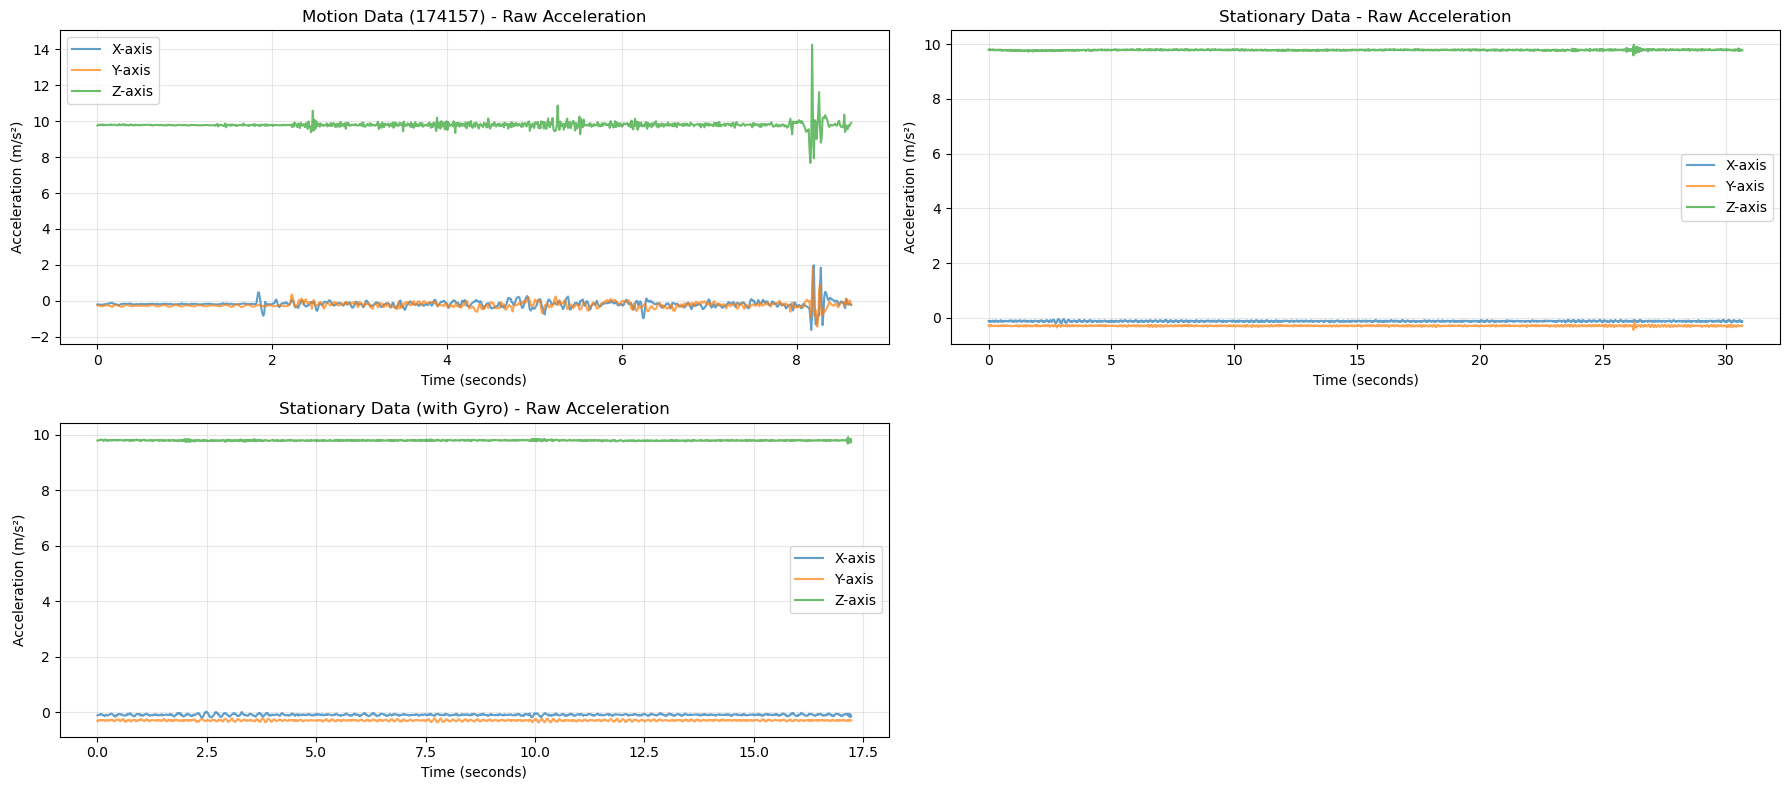

Displayed acceleration data for 3 datasets


In [36]:
# Visualize the raw acceleration data for all datasets
all_dataset_list = [(info['name'], info['data']) for info in datasets.values()]

# Calculate grid size for subplots
n_datasets = len(all_dataset_list)
cols = 2
rows = (n_datasets + cols - 1) // cols  # Ceiling division

fig, axes = plt.subplots(rows, cols, figsize=(18, 4*rows))

# Handle different cases for axes object
if n_datasets == 1:
    # Single plot case
    axes = [axes] if not hasattr(axes, '__len__') else axes.flatten()
elif rows == 1:
    # Single row case
    axes = axes if hasattr(axes, '__len__') else [axes]
else:
    # Multiple rows case
    axes = axes.flatten()

for i, (title, data) in enumerate(all_dataset_list):
    ax = axes[i]
    
    ax.plot(data['time'], data['acc_x'], label='X-axis', alpha=0.7)
    ax.plot(data['time'], data['acc_y'], label='Y-axis', alpha=0.7)
    ax.plot(data['time'], data['acc_z'], label='Z-axis', alpha=0.7)
    ax.set_title(f'{title} - Raw Acceleration')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Acceleration (m/s²)')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide any unused subplots
for i in range(n_datasets, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

print(f"Displayed acceleration data for {n_datasets} datasets")

## Analysis Approach

To find the table width, we'll:

1. **Remove gravity bias** using the stationary data
2. **Filter the acceleration data** to focus on the horizontal motion
3. **Integrate acceleration** to get velocity and then position
4. **Identify table crossing events** by analyzing the motion patterns
5. **Calculate the table width** from the distance traveled

In [37]:
# Enhanced gravity compensation with orientation-based approach
motion_datasets_corrected = {}

print("=== GRAVITY COMPENSATION METHODS ===")

for filename, dataset_info in motion_datasets.items():
    data = dataset_info['data']
    title = dataset_info['name']
    
    print(f"\nProcessing {title}:")
    
    if dataset_info['has_gyro']:
        print("  Using ORIENTATION-BASED gravity compensation with gyroscope")
        
        # Use orientation-based gravity compensation
        gravity_estimates = estimate_orientation_and_gravity(data, dataset_info['gyro_data'])
        corrected_data = remove_orientation_based_gravity(data, gravity_estimates)
        
        gravity_method = "orientation-based"
        
    else:
        print("  Using STATIC gravity compensation (no gyro available)")
        
        # Fall back to static gravity compensation
        # Use stationary data if available, otherwise estimate from current data
        if stationary_data is not None:
            gravity_bias_x = stationary_data['acc_x'].mean()
            gravity_bias_y = stationary_data['acc_y'].mean()
            gravity_bias_z = stationary_data['acc_z'].mean()
            print(f"  Using stationary reference: ({gravity_bias_x:.3f}, {gravity_bias_y:.3f}, {gravity_bias_z:.3f}) m/s²")
        else:
            # Estimate from current dataset
            gravity_bias_x = data['acc_x'].median()
            gravity_bias_y = data['acc_y'].median()
            gravity_bias_z = data['acc_z'].median()
            print(f"  Using dataset median: ({gravity_bias_x:.3f}, {gravity_bias_y:.3f}, {gravity_bias_z:.3f}) m/s²")
        
        # Apply static bias removal
        corrected_data = data.copy()
        corrected_data['acc_x_corrected'] = data['acc_x'] - gravity_bias_x
        corrected_data['acc_y_corrected'] = data['acc_y'] - gravity_bias_y
        corrected_data['acc_z_corrected'] = data['acc_z'] - gravity_bias_z
        
        gravity_method = "static-bias"
    
    # Store corrected data
    motion_datasets_corrected[filename] = {
        **dataset_info,  # Copy original info
        'data': corrected_data,
        'gravity_method': gravity_method
    }

print(f"\n=== GRAVITY CORRECTION SUMMARY ===")
for filename, dataset_info in motion_datasets_corrected.items():
    method = dataset_info['gravity_method']
    print(f"{dataset_info['name']}: {method}")

print(f"\nGravity correction applied to {len(motion_datasets_corrected)} motion datasets")

=== GRAVITY COMPENSATION METHODS ===

Processing Motion Data (174157):
  Using ORIENTATION-BASED gravity compensation with gyroscope
Initial gravity in device frame: (-0.210, -0.283, 9.804) m/s²
Orientation-based gravity compensation:
  Gravity range X: [-0.337, -0.161] m/s²
  Gravity range Y: [-0.452, -0.255] m/s²
  Gravity range Z: [9.795, 9.805] m/s²

=== GRAVITY CORRECTION SUMMARY ===
Motion Data (174157): orientation-based

Gravity correction applied to 1 motion datasets


Using raw gravity-compensated data for 1 motion datasets
NOTE: Skipping low-pass filtering to preserve signal integrity for integration


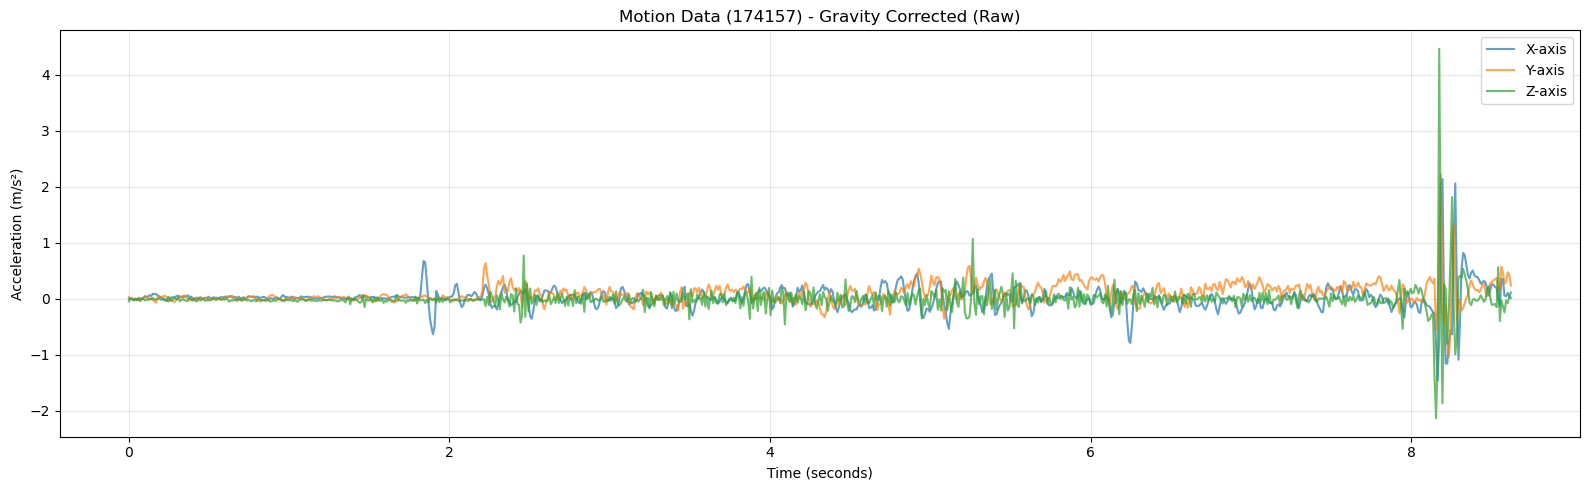

Using raw gravity-compensated acceleration data for integration!


In [38]:
# Skip filtering - use raw gravity-compensated data for better integration results
# Filtering can introduce phase delays and artifacts that mess up the double integration

# Use the corrected data directly for integration
motion_datasets_filtered = motion_datasets_corrected.copy()

print(f"Using raw gravity-compensated data for {len(motion_datasets_filtered)} motion datasets")
print("NOTE: Skipping low-pass filtering to preserve signal integrity for integration")

# Plot corrected data for first two datasets
motion_items = list(motion_datasets_filtered.items())
datasets_to_plot = motion_items[:2] if len(motion_items) >= 2 else motion_items

if datasets_to_plot:
    fig, axes = plt.subplots(len(datasets_to_plot), 1, figsize=(16, 5*len(datasets_to_plot)))
    
    # Handle single dataset case
    if len(datasets_to_plot) == 1:
        axes = [axes]
    
    for i, (filename, dataset_info) in enumerate(datasets_to_plot):
        data = dataset_info['data']
        title = dataset_info['name']
        
        # Plot gravity-corrected data
        ax = axes[i]
        ax.plot(data['time'], data['acc_x_corrected'], label='X-axis', alpha=0.7)
        ax.plot(data['time'], data['acc_y_corrected'], label='Y-axis', alpha=0.7)
        ax.plot(data['time'], data['acc_z_corrected'], label='Z-axis', alpha=0.7)
        ax.set_title(f'{title} - Gravity Corrected (Raw)')
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('Acceleration (m/s²)')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("Using raw gravity-compensated acceleration data for integration!")

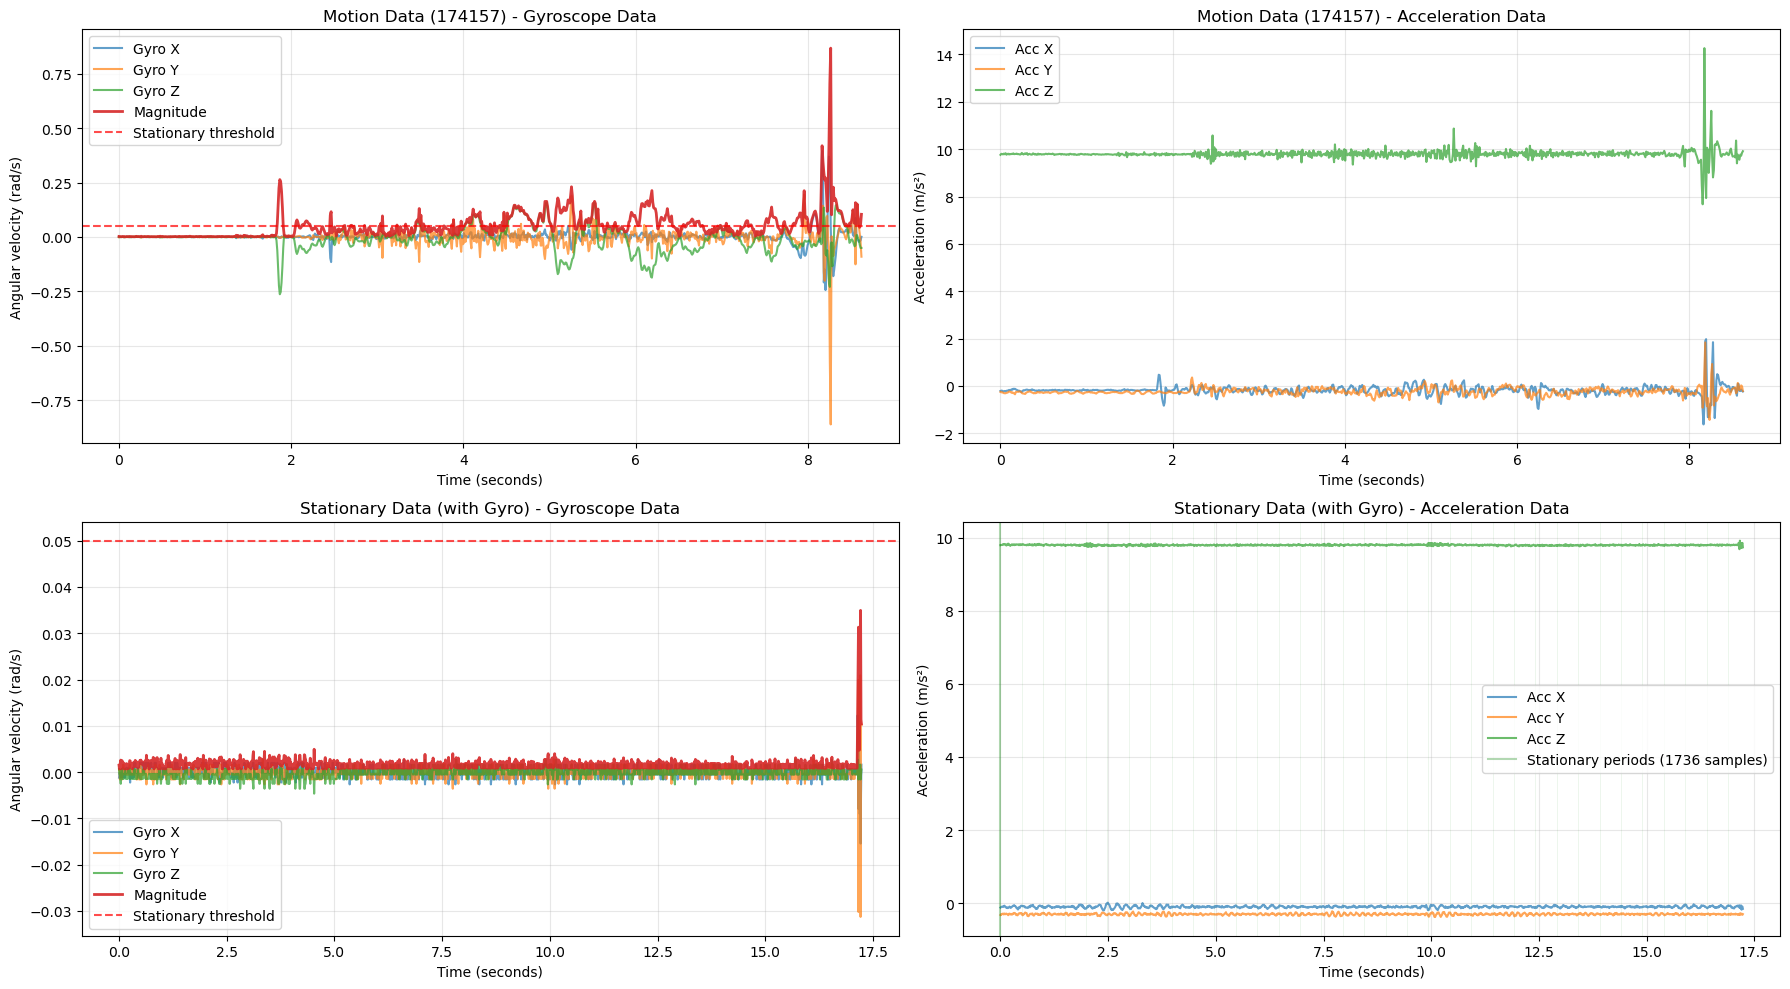

Displayed gyro analysis for 2 datasets with gyroscope data


In [39]:
# Visualize gyroscope data and stationary period detection for gyro-enabled datasets
gyro_enabled = [info for info in datasets.values() if info['has_gyro']]

if gyro_enabled:
    fig, axes = plt.subplots(len(gyro_enabled), 2, figsize=(18, 5*len(gyro_enabled)))
    
    if len(gyro_enabled) == 1:
        axes = axes.reshape(1, -1)
    
    for i, dataset_info in enumerate(gyro_enabled):
        data = dataset_info['data']
        gyro_data = dataset_info['gyro_data']
        title = dataset_info['name']
        
        # Calculate gyro magnitude
        gyro_magnitude = np.sqrt(data['gyro_x']**2 + data['gyro_y']**2 + data['gyro_z']**2)
        
        # Plot gyroscope data
        ax1 = axes[i, 0]
        ax1.plot(data['time'], data['gyro_x'], label='Gyro X', alpha=0.7)
        ax1.plot(data['time'], data['gyro_y'], label='Gyro Y', alpha=0.7)
        ax1.plot(data['time'], data['gyro_z'], label='Gyro Z', alpha=0.7)
        ax1.plot(data['time'], gyro_magnitude, label='Magnitude', alpha=0.9, linewidth=2)
        ax1.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='Stationary threshold')
        ax1.set_title(f'{title} - Gyroscope Data')
        ax1.set_xlabel('Time (seconds)')
        ax1.set_ylabel('Angular velocity (rad/s)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot acceleration with stationary periods highlighted
        ax2 = axes[i, 1]
        ax2.plot(data['time'], data['acc_x'], label='Acc X', alpha=0.7)
        ax2.plot(data['time'], data['acc_y'], label='Acc Y', alpha=0.7)
        ax2.plot(data['time'], data['acc_z'], label='Acc Z', alpha=0.7)
        
        # Highlight stationary periods if this is stationary data
        if dataset_info['type'] == 'stationary':
            stationary_mask = gyro_magnitude < 0.05
            stationary_times = data['time'][stationary_mask]
            if len(stationary_times) > 0:
                for t in stationary_times[::50]:  # Show every 50th point to avoid clutter
                    ax2.axvline(x=t, color='green', alpha=0.1, linewidth=0.5)
                ax2.axvline(x=stationary_times.iloc[0], color='green', alpha=0.3, 
                           label=f'Stationary periods ({stationary_mask.sum()} samples)')
        
        ax2.set_title(f'{title} - Acceleration Data')
        ax2.set_xlabel('Time (seconds)')
        ax2.set_ylabel('Acceleration (m/s²)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    print(f"Displayed gyro analysis for {len(gyro_enabled)} datasets with gyroscope data")
else:
    print("No datasets with gyroscope data found for visualization")

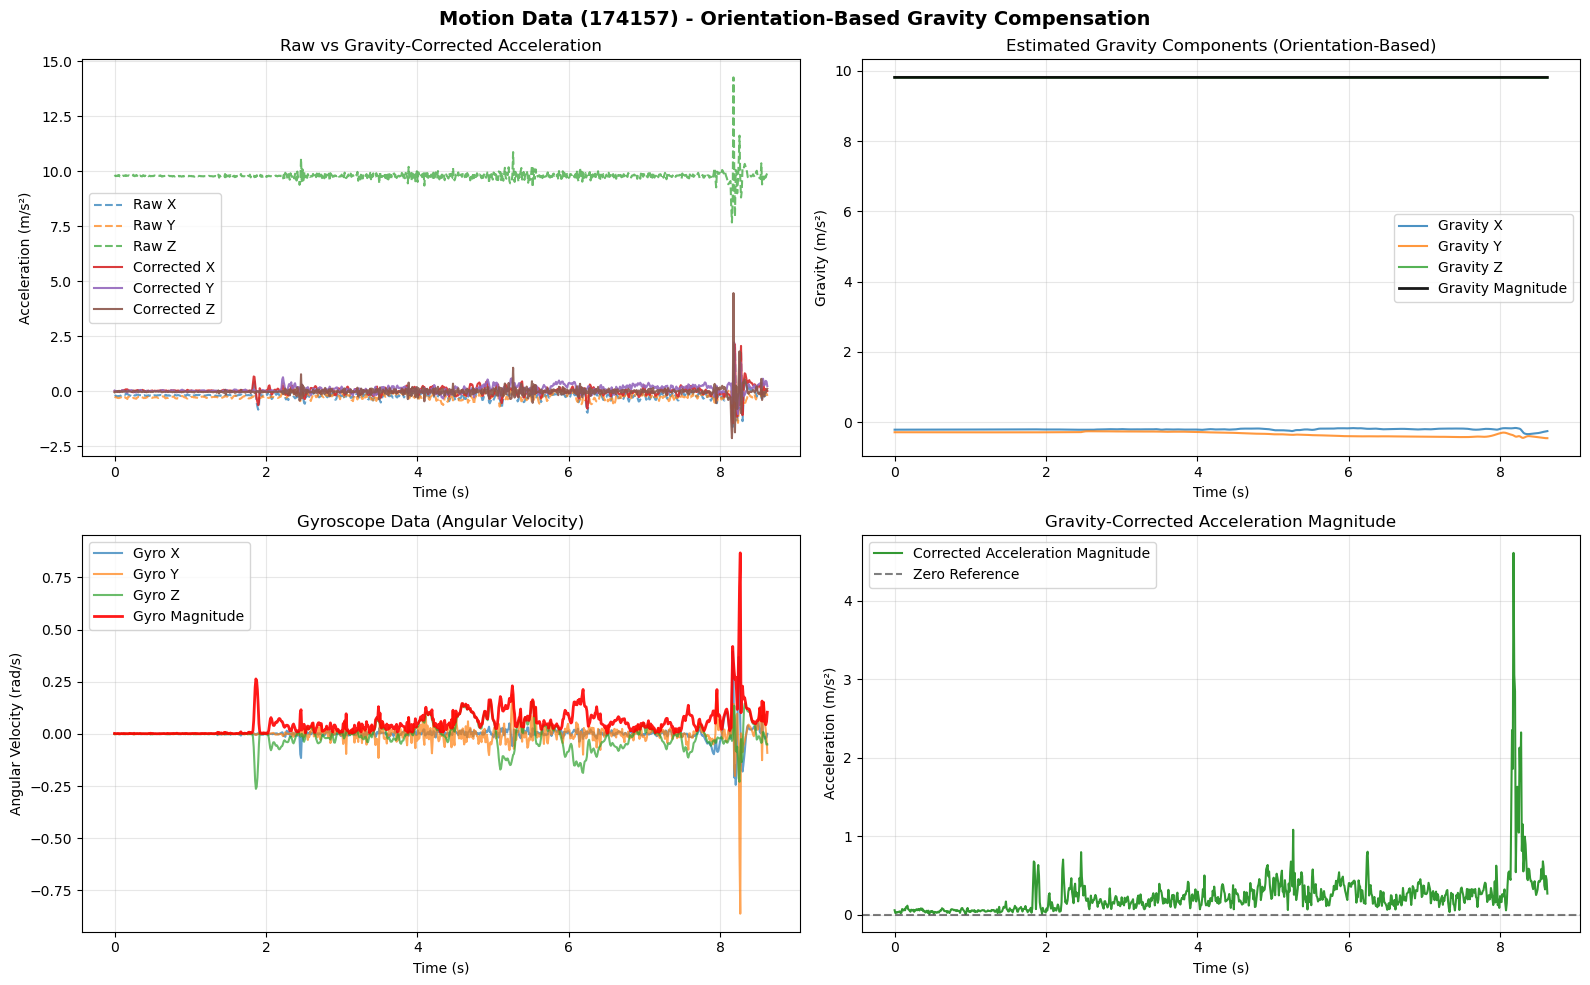


Gravity estimate variations for Motion Data (174157):
  X-axis std: 0.025 m/s²
  Y-axis std: 0.059 m/s²
  Z-axis std: 0.002 m/s²
  Average gravity magnitude: 9.810 m/s²


In [40]:
# Visualize orientation-based gravity compensation
gyro_motion_datasets = {k: v for k, v in motion_datasets_corrected.items() if v['has_gyro']}

if gyro_motion_datasets:
    for filename, dataset_info in gyro_motion_datasets.items():
        data = dataset_info['data']
        title = dataset_info['name']
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle(f'{title} - Orientation-Based Gravity Compensation', fontsize=14, fontweight='bold')
        
        # Plot 1: Raw vs Corrected Acceleration
        ax1 = axes[0, 0]
        ax1.plot(data['time'], data['acc_x'], label='Raw X', alpha=0.7, linestyle='--')
        ax1.plot(data['time'], data['acc_y'], label='Raw Y', alpha=0.7, linestyle='--')
        ax1.plot(data['time'], data['acc_z'], label='Raw Z', alpha=0.7, linestyle='--')
        ax1.plot(data['time'], data['acc_x_corrected'], label='Corrected X', alpha=0.9)
        ax1.plot(data['time'], data['acc_y_corrected'], label='Corrected Y', alpha=0.9)
        ax1.plot(data['time'], data['acc_z_corrected'], label='Corrected Z', alpha=0.9)
        ax1.set_title('Raw vs Gravity-Corrected Acceleration')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Acceleration (m/s²)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Estimated Gravity Components
        ax2 = axes[0, 1]
        if 'gravity_x_est' in data.columns:
            ax2.plot(data['time'], data['gravity_x_est'], label='Gravity X', alpha=0.8)
            ax2.plot(data['time'], data['gravity_y_est'], label='Gravity Y', alpha=0.8)
            ax2.plot(data['time'], data['gravity_z_est'], label='Gravity Z', alpha=0.8)
            
            # Show gravity magnitude
            gravity_mag = np.sqrt(data['gravity_x_est']**2 + data['gravity_y_est']**2 + data['gravity_z_est']**2)
            ax2.plot(data['time'], gravity_mag, label='Gravity Magnitude', alpha=0.9, linewidth=2, color='black')
            
        ax2.set_title('Estimated Gravity Components (Orientation-Based)')
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Gravity (m/s²)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Gyroscope Data
        ax3 = axes[1, 0]
        if 'gyro_x' in data.columns:
            ax3.plot(data['time'], data['gyro_x'], label='Gyro X', alpha=0.7)
            ax3.plot(data['time'], data['gyro_y'], label='Gyro Y', alpha=0.7)
            ax3.plot(data['time'], data['gyro_z'], label='Gyro Z', alpha=0.7)
            
            gyro_mag = np.sqrt(data['gyro_x']**2 + data['gyro_y']**2 + data['gyro_z']**2)
            ax3.plot(data['time'], gyro_mag, label='Gyro Magnitude', alpha=0.9, linewidth=2, color='red')
            
        ax3.set_title('Gyroscope Data (Angular Velocity)')
        ax3.set_xlabel('Time (s)')
        ax3.set_ylabel('Angular Velocity (rad/s)')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Gravity-corrected acceleration magnitude
        ax4 = axes[1, 1]
        corrected_mag = np.sqrt(data['acc_x_corrected']**2 + data['acc_y_corrected']**2 + data['acc_z_corrected']**2)
        ax4.plot(data['time'], corrected_mag, label='Corrected Acceleration Magnitude', alpha=0.8, color='green')
        ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5, label='Zero Reference')
        ax4.set_title('Gravity-Corrected Acceleration Magnitude')
        ax4.set_xlabel('Time (s)')
        ax4.set_ylabel('Acceleration (m/s²)')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print some statistics
        if 'gravity_x_est' in data.columns:
            gravity_variation_x = data['gravity_x_est'].std()
            gravity_variation_y = data['gravity_y_est'].std()
            gravity_variation_z = data['gravity_z_est'].std()
            print(f"\nGravity estimate variations for {title}:")
            print(f"  X-axis std: {gravity_variation_x:.3f} m/s²")
            print(f"  Y-axis std: {gravity_variation_y:.3f} m/s²")
            print(f"  Z-axis std: {gravity_variation_z:.3f} m/s²")
            
            avg_gravity_mag = np.sqrt(data['gravity_x_est']**2 + data['gravity_y_est']**2 + data['gravity_z_est']**2).mean()
            print(f"  Average gravity magnitude: {avg_gravity_mag:.3f} m/s²")
else:
    print("No gyro-enabled motion datasets found for orientation-based visualization")

In [41]:
# Integrate acceleration to get velocity and position
def integrate_motion(data, integration_method='trapezoid'):
    """
    Double integrate acceleration to get position using raw gravity-compensated data
    
    Parameters:
    data: DataFrame with corrected acceleration data
    integration_method: 'trapezoid' for cumulative_trapezoid or 'simpson' for cumulative_simpson
    """
    dt = np.diff(data['time'])
    dt = np.append(dt, dt[-1])  # Assume last interval same as previous
    
    # Choose integration function based on method
    if integration_method == 'simpson':
        integrate_func = cumulative_simpson
        print(f"Using Simpson's rule for integration")
    else:  # default to trapezoid
        integrate_func = cumulative_trapezoid
        print(f"Using trapezoidal rule for integration")
    
    # Use raw gravity-compensated acceleration data (no filtering)
    # Integrate acceleration to get velocity
    vel_x = integrate_func(data['acc_x_corrected'], data['time'], initial=0)
    vel_y = integrate_func(data['acc_y_corrected'], data['time'], initial=0)
    vel_z = integrate_func(data['acc_z_corrected'], data['time'], initial=0)
    
    # Integrate velocity to get position
    pos_x = integrate_func(vel_x, data['time'], initial=0)
    pos_y = integrate_func(vel_y, data['time'], initial=0)
    pos_z = integrate_func(vel_z, data['time'], initial=0)
    
    data_integrated = data.copy()
    data_integrated['vel_x'] = vel_x
    data_integrated['vel_y'] = vel_y
    data_integrated['vel_z'] = vel_z
    data_integrated['pos_x'] = pos_x
    data_integrated['pos_y'] = pos_y
    data_integrated['pos_z'] = pos_z
    
    return data_integrated

# Choose integration method
integration_method = 'trapezoid'  # Change to 'simpson' to use Simpson's rule

# Integrate all motion datasets using raw gravity-compensated data
motion_datasets_integrated = {}

print(f"Integration using raw gravity-compensated acceleration data with {integration_method} method:")
for filename, dataset_info in motion_datasets_filtered.items():
    integrated_data = integrate_motion(dataset_info['data'], integration_method)
    motion_datasets_integrated[filename] = {
        **dataset_info,  # Copy original info
        'data': integrated_data
    }
    
    # Print final position for each dataset
    final_x = integrated_data['pos_x'].iloc[-1]
    final_y = integrated_data['pos_y'].iloc[-1]
    print(f"{dataset_info['name']} - Final position: X={final_x:.3f}m, Y={final_y:.3f}m")

print(f"\nIntegration completed for {len(motion_datasets_integrated)} motion datasets")
print("NOTE: Using raw acceleration data should give more accurate displacement estimates")
print(f"Integration method used: {integration_method}")

Integration using raw gravity-compensated acceleration data with trapezoid method:
Using trapezoidal rule for integration
Motion Data (174157) - Final position: X=0.751m, Y=2.246m

Integration completed for 1 motion datasets
NOTE: Using raw acceleration data should give more accurate displacement estimates
Integration method used: trapezoid


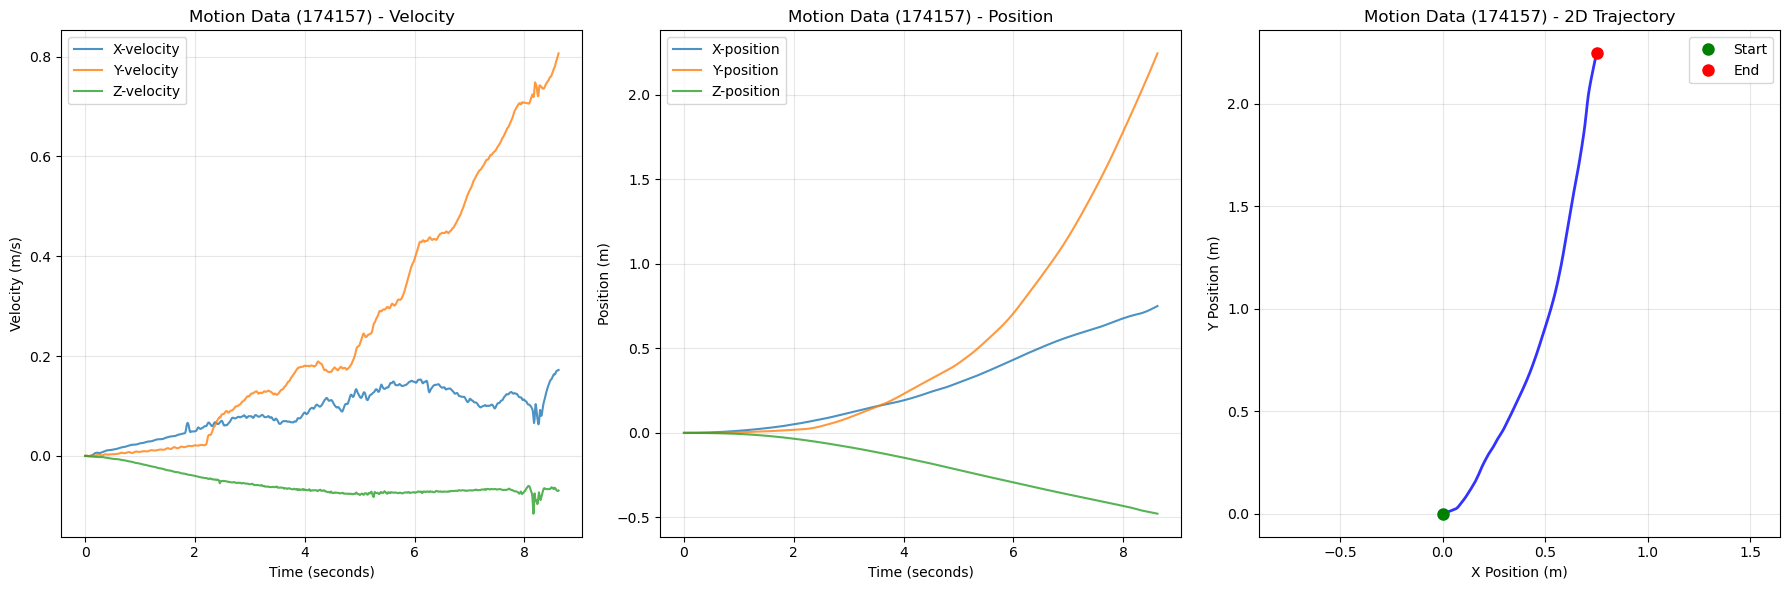

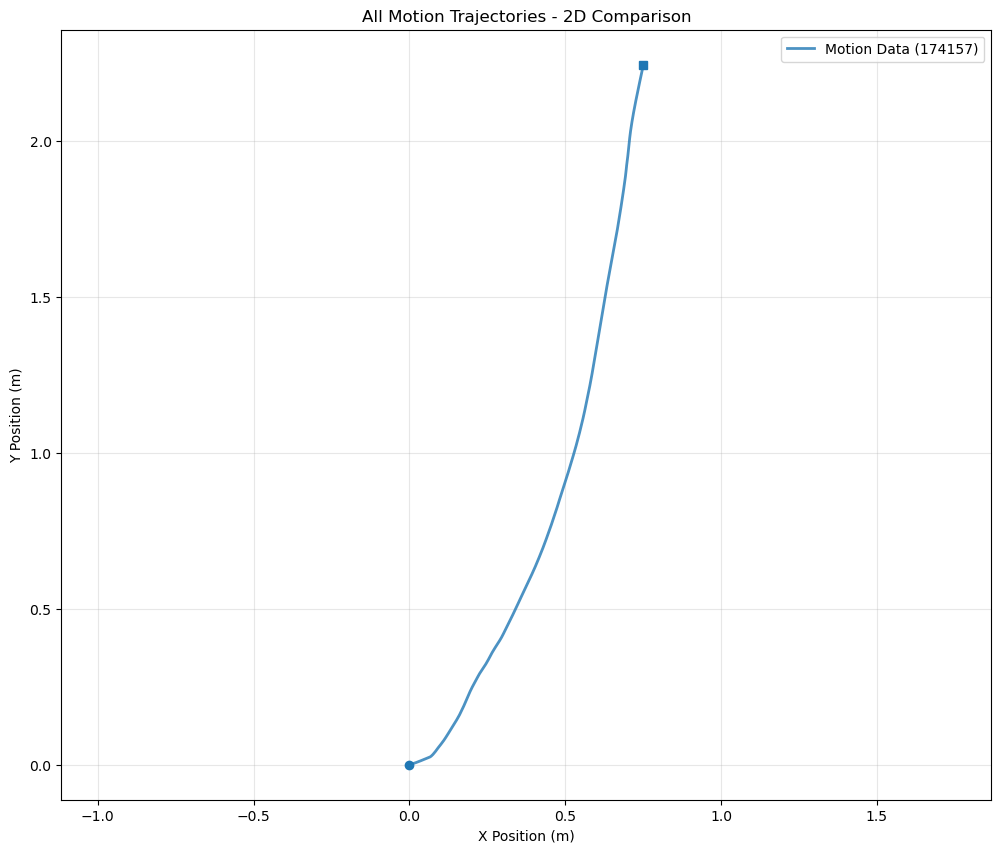

Plotted trajectories for 1 motion datasets


In [42]:
# Plot velocity and position trajectories for first two datasets
motion_items = list(motion_datasets_integrated.items())
datasets_to_plot = motion_items[:2] if len(motion_items) >= 2 else motion_items

if datasets_to_plot:
    fig, axes = plt.subplots(len(datasets_to_plot), 3, figsize=(18, 6*len(datasets_to_plot)))
    
    # Handle single dataset case
    if len(datasets_to_plot) == 1:
        axes = axes.reshape(1, -1)

    for i, (filename, dataset_info) in enumerate(datasets_to_plot):
        data = dataset_info['data']
        title = dataset_info['name']
        
        # Velocity plots
        ax_vel = axes[i, 0]
        ax_vel.plot(data['time'], data['vel_x'], label='X-velocity', alpha=0.8)
        ax_vel.plot(data['time'], data['vel_y'], label='Y-velocity', alpha=0.8)
        ax_vel.plot(data['time'], data['vel_z'], label='Z-velocity', alpha=0.8)
        ax_vel.set_title(f'{title} - Velocity')
        ax_vel.set_xlabel('Time (seconds)')
        ax_vel.set_ylabel('Velocity (m/s)')
        ax_vel.legend()
        ax_vel.grid(True, alpha=0.3)
        
        # Position plots
        ax_pos = axes[i, 1]
        ax_pos.plot(data['time'], data['pos_x'], label='X-position', alpha=0.8)
        ax_pos.plot(data['time'], data['pos_y'], label='Y-position', alpha=0.8)
        ax_pos.plot(data['time'], data['pos_z'], label='Z-position', alpha=0.8)
        ax_pos.set_title(f'{title} - Position')
        ax_pos.set_xlabel('Time (seconds)')
        ax_pos.set_ylabel('Position (m)')
        ax_pos.legend()
        ax_pos.grid(True, alpha=0.3)
        
        # 2D trajectory (top-down view)
        ax_traj = axes[i, 2]
        ax_traj.plot(data['pos_x'], data['pos_y'], 'b-', alpha=0.8, linewidth=2)
        ax_traj.plot(data['pos_x'].iloc[0], data['pos_y'].iloc[0], 'go', markersize=8, label='Start')
        ax_traj.plot(data['pos_x'].iloc[-1], data['pos_y'].iloc[-1], 'ro', markersize=8, label='End')
        ax_traj.set_title(f'{title} - 2D Trajectory')
        ax_traj.set_xlabel('X Position (m)')
        ax_traj.set_ylabel('Y Position (m)')
        ax_traj.legend()
        ax_traj.grid(True, alpha=0.3)
        ax_traj.axis('equal')

    plt.tight_layout()
    plt.show()

# Plot all 2D trajectories together for comparison
if motion_datasets_integrated:
    plt.figure(figsize=(12, 10))
    colors = plt.cm.tab10(np.linspace(0, 1, len(motion_datasets_integrated)))
    
    for i, (filename, dataset_info) in enumerate(motion_datasets_integrated.items()):
        data = dataset_info['data']
        title = dataset_info['name']
        color = colors[i]
        
        plt.plot(data['pos_x'], data['pos_y'], color=color, alpha=0.8, linewidth=2, label=title)
        plt.plot(data['pos_x'].iloc[0], data['pos_y'].iloc[0], 'o', color=color, markersize=6)
        plt.plot(data['pos_x'].iloc[-1], data['pos_y'].iloc[-1], 's', color=color, markersize=6)

    plt.title('All Motion Trajectories - 2D Comparison')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()
    
    print(f"Plotted trajectories for {len(motion_datasets_integrated)} motion datasets")
else:
    print("No motion datasets available for plotting")

## Table Width Analysis

Now let's analyze the motion patterns to estimate the table width. We'll look for:
1. **Direction changes** in the horizontal plane (X-Y)
2. **Peak-to-peak distances** in the motion trajectory
3. **Velocity reversals** that indicate direction changes

In [43]:
def analyze_table_width(data, title):
    """Analyze motion data to estimate table width"""
    
    # Calculate horizontal distance (assuming motion is primarily in X-Y plane)
    horizontal_distance = np.sqrt(data['pos_x']**2 + data['pos_y']**2)
    
    # Find the maximum extent in each direction
    max_x = data['pos_x'].max() - data['pos_x'].min()
    max_y = data['pos_y'].max() - data['pos_y'].min()
    
    # Find velocity reversals (direction changes)
    vel_x_sign_changes = np.diff(np.sign(data['vel_x']))
    vel_y_sign_changes = np.diff(np.sign(data['vel_y']))
    
    x_reversals = np.where(vel_x_sign_changes != 0)[0]
    y_reversals = np.where(vel_y_sign_changes != 0)[0]
    
    print(f"\n{title} Analysis:")
    print(f"Maximum X displacement: {max_x:.3f} m")
    print(f"Maximum Y displacement: {max_y:.3f} m")
    print(f"Maximum horizontal distance from origin: {horizontal_distance.max():.3f} m")
    print(f"Number of X-direction reversals: {len(x_reversals)}")
    print(f"Number of Y-direction reversals: {len(y_reversals)}")
    
    # Determine which axis shows the primary table crossing motion
    if max_x > max_y:
        primary_axis = 'X'
        primary_displacement = max_x
        primary_reversals = len(x_reversals)
    else:
        primary_axis = 'Y'
        primary_displacement = max_y
        primary_reversals = len(y_reversals)
    
    print(f"Primary motion axis: {primary_axis}")
    print(f"Primary displacement: {primary_displacement:.3f} m")
    
    # If the phone crossed the table twice, the displacement should be roughly 2x table width
    if primary_reversals >= 2:  # At least one back-and-forth motion
        estimated_table_width = primary_displacement / 2
        print(f"Estimated table width (displacement/2): {estimated_table_width:.3f} m")
    else:
        estimated_table_width = primary_displacement
        print(f"Estimated table width (single crossing): {estimated_table_width:.3f} m")
    
    return estimated_table_width, primary_axis, primary_displacement

# Analyze all motion datasets
basic_width_estimates = []
dataset_analysis_results = {}

for filename, dataset_info in motion_datasets_integrated.items():
    data = dataset_info['data']
    title = dataset_info['name']
    
    width, axis, disp = analyze_table_width(data, title)
    basic_width_estimates.append(width)
    
    dataset_analysis_results[filename] = {
        'name': title,
        'width_estimate': width,
        'primary_axis': axis,
        'displacement': disp
    }

print(f"\nBasic analysis completed for {len(basic_width_estimates)} datasets")


Motion Data (174157) Analysis:
Maximum X displacement: 0.751 m
Maximum Y displacement: 2.246 m
Maximum horizontal distance from origin: 2.368 m
Number of X-direction reversals: 3
Number of Y-direction reversals: 3
Primary motion axis: Y
Primary displacement: 2.246 m
Estimated table width (displacement/2): 1.123 m

Basic analysis completed for 1 datasets


In [44]:
# Enhanced analysis: Look for peak-to-peak distances along the primary motion axis
def detailed_table_analysis(data, title):
    """More detailed analysis using peak detection"""
    
    # Determine primary motion axis based on standard deviation
    std_x = data['pos_x'].std()
    std_y = data['pos_y'].std()
    
    if std_x > std_y:
        primary_pos = data['pos_x'].values
        primary_axis = 'X'
    else:
        primary_pos = data['pos_y'].values
        primary_axis = 'Y'
    
    # Find peaks and valleys in the position data
    peaks, _ = signal.find_peaks(primary_pos, height=None, distance=20)
    valleys, _ = signal.find_peaks(-primary_pos, height=None, distance=20)
    
    print(f"\n{title} - Detailed Analysis:")
    print(f"Primary motion axis: {primary_axis}")
    print(f"Found {len(peaks)} peaks and {len(valleys)} valleys")
    
    # Calculate distances between extremes
    extremes = np.sort(np.concatenate([peaks, valleys]))
    extreme_positions = primary_pos[extremes]
    
    if len(extreme_positions) >= 2:
        # Calculate consecutive distances between extremes
        distances = []
        for i in range(len(extreme_positions) - 1):
            dist = abs(extreme_positions[i+1] - extreme_positions[i])
            distances.append(dist)
            print(f"Distance {i+1}: {dist:.3f} m")
        
        if distances:
            mean_crossing_distance = np.mean(distances)
            median_crossing_distance = np.median(distances)
            
            print(f"Mean crossing distance: {mean_crossing_distance:.3f} m")
            print(f"Median crossing distance: {median_crossing_distance:.3f} m")
            
            return median_crossing_distance, distances
    
    return None, []

# Perform detailed analysis on all datasets
detailed_width_estimates = []
all_distances = []
detailed_analysis_results = {}

for filename, dataset_info in motion_datasets_integrated.items():
    data = dataset_info['data']
    title = dataset_info['name']
    
    width_detailed, distances = detailed_table_analysis(data, title)
    
    if width_detailed is not None:
        detailed_width_estimates.append(width_detailed)
        all_distances.extend(distances)
    
    detailed_analysis_results[filename] = {
        'name': title,
        'detailed_width': width_detailed,
        'distances': distances
    }

print(f"\nDetailed analysis completed for {len(motion_datasets_integrated)} datasets")
print(f"Valid detailed estimates: {len(detailed_width_estimates)}")
print(f"Total individual crossing distances: {len(all_distances)}")


Motion Data (174157) - Detailed Analysis:
Primary motion axis: Y
Found 1 peaks and 1 valleys
Distance 1: 0.000 m
Mean crossing distance: 0.000 m
Median crossing distance: 0.000 m

Detailed analysis completed for 1 datasets
Valid detailed estimates: 1
Total individual crossing distances: 1



FINAL TABLE WIDTH ESTIMATION - WITH 1 MOTION DATASETS

Basic Analysis Results:
Motion Data (174157): 1.123 m

Detailed Analysis Results:
Motion Data (174157): 0.000 m

STATISTICAL SUMMARY
Number of estimates: 2
Mean estimate: 0.561 m
Median estimate: 0.561 m
Standard deviation: 0.561 m
Min estimate: 0.000 m
Max estimate: 1.123 m
Range: 1.123 m

FINAL TABLE WIDTH ESTIMATE
Best estimate (median): 0.561 ± 0.561 m

In different units:
Meters: 0.561 ± 0.561 m
Centimeters: 56.1 ± 56.1 cm
Inches: 22.1 ± 22.1 inches
Feet: 1.84 ± 1.84 feet


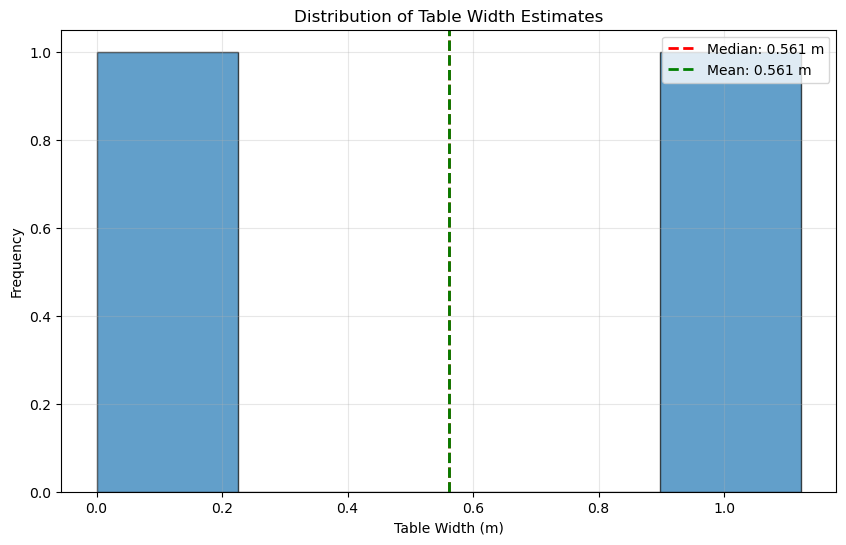


95% Confidence Interval: 0.561 ± 1.100 m
95% CI Range: [-0.539, 1.662] m

ALL INDIVIDUAL CROSSING DISTANCES
Crossing 1: 0.000 m (0.0 cm)

Distance statistics:
Mean crossing distance: 0.000 m
Median crossing distance: 0.000 m
Std deviation: 0.000 m

DATASET PROCESSING SUMMARY
Total datasets found: 3
Stationary datasets: 2
Motion datasets processed: 1
Files processed:
  - sensorLog_20250904T174157.txt: Motion Data (174157) (motion)
  - stationary data.txt: Stationary Data (stationary)
  - stationary with gyro.txt: Stationary Data (with Gyro) (stationary)


In [45]:
# Final table width estimation with all dynamically loaded datasets
print("\n" + "="*70)
print(f"FINAL TABLE WIDTH ESTIMATION - WITH {len(motion_datasets_integrated)} MOTION DATASETS")
print("="*70)

all_estimates = []

# Add basic analysis results
print("\nBasic Analysis Results:")
for i, (filename, result) in enumerate(dataset_analysis_results.items(), 1):
    estimate = result['width_estimate']
    if estimate is not None:
        all_estimates.append(estimate)
        print(f"{result['name']}: {estimate:.3f} m")

# Add detailed analysis results
print("\nDetailed Analysis Results:")
for i, (filename, result) in enumerate(detailed_analysis_results.items(), 1):
    estimate = result['detailed_width']
    if estimate is not None:
        all_estimates.append(estimate)
        print(f"{result['name']}: {estimate:.3f} m")

if all_estimates:
    # Calculate statistics
    final_estimate = np.median(all_estimates)
    mean_estimate = np.mean(all_estimates)
    std_estimate = np.std(all_estimates)
    min_estimate = np.min(all_estimates)
    max_estimate = np.max(all_estimates)
    
    print(f"\n" + "="*40)
    print("STATISTICAL SUMMARY")
    print("="*40)
    print(f"Number of estimates: {len(all_estimates)}")
    print(f"Mean estimate: {mean_estimate:.3f} m")
    print(f"Median estimate: {final_estimate:.3f} m")
    print(f"Standard deviation: {std_estimate:.3f} m")
    print(f"Min estimate: {min_estimate:.3f} m")
    print(f"Max estimate: {max_estimate:.3f} m")
    print(f"Range: {max_estimate - min_estimate:.3f} m")
    
    print(f"\n" + "="*40)
    print("FINAL TABLE WIDTH ESTIMATE")
    print("="*40)
    print(f"Best estimate (median): {final_estimate:.3f} ± {std_estimate:.3f} m")
    
    # Convert to common units
    print(f"\nIn different units:")
    print(f"Meters: {final_estimate:.3f} ± {std_estimate:.3f} m")
    print(f"Centimeters: {final_estimate*100:.1f} ± {std_estimate*100:.1f} cm")
    print(f"Inches: {final_estimate*39.37:.1f} ± {std_estimate*39.37:.1f} inches")
    print(f"Feet: {final_estimate*3.28:.2f} ± {std_estimate*3.28:.2f} feet")
    
    # Create a histogram of all estimates
    plt.figure(figsize=(10, 6))
    plt.hist(all_estimates, bins=max(5, len(all_estimates)//2), alpha=0.7, edgecolor='black')
    plt.axvline(final_estimate, color='red', linestyle='--', linewidth=2, label=f'Median: {final_estimate:.3f} m')
    plt.axvline(mean_estimate, color='green', linestyle='--', linewidth=2, label=f'Mean: {mean_estimate:.3f} m')
    plt.xlabel('Table Width (m)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Table Width Estimates')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Summary statistics
    confidence_interval = 1.96 * std_estimate  # 95% confidence interval
    print(f"\n95% Confidence Interval: {final_estimate:.3f} ± {confidence_interval:.3f} m")
    print(f"95% CI Range: [{final_estimate - confidence_interval:.3f}, {final_estimate + confidence_interval:.3f}] m")
    
else:
    print("Could not estimate table width from the available data.")

# Display all individual distance measurements
if all_distances:
    print(f"\n" + "="*40)
    print("ALL INDIVIDUAL CROSSING DISTANCES")
    print("="*40)
    for i, dist in enumerate(all_distances, 1):
        print(f"Crossing {i}: {dist:.3f} m ({dist*100:.1f} cm)")
    
    print(f"\nDistance statistics:")
    print(f"Mean crossing distance: {np.mean(all_distances):.3f} m")
    print(f"Median crossing distance: {np.median(all_distances):.3f} m")
    print(f"Std deviation: {np.std(all_distances):.3f} m")

# Print summary of all datasets processed
print(f"\n" + "="*40)
print("DATASET PROCESSING SUMMARY")
print("="*40)
print(f"Total datasets found: {len(datasets)}")
print(f"Stationary datasets: {len(stationary_datasets)}")
print(f"Motion datasets processed: {len(motion_datasets_integrated)}")
print(f"Files processed:")
for filename, info in datasets.items():
    print(f"  - {filename}: {info['name']} ({info['type']})")